In [37]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [38]:
dataset_path = "/home/hilinxinhui/Desktop/data-driven-capacity-estimation-from-voltage-relaxation"
dataset_names = ["Dataset_1_NCA_battery/", "Dataset_2_NCM_battery/", "Dataset_3_NCM_NCA_battery/"]
dataset_id = 1
dataset_name = dataset_names[dataset_id-1]
os.chdir(os.path.join(dataset_path, dataset_name))

print(os.getcwd())

# 删已经生成的pkl文件
for folder_name, subfolder_names, file_names in os.walk(os.getcwd()):
    for file_name in file_names:
        if file_name.endswith(".pkl"):
            os.remove(os.path.join(folder_name, file_name))

/home/hilinxinhui/Desktop/data-driven-capacity-estimation-from-voltage-relaxation/Dataset_1_NCA_battery


In [39]:
def gen_rul(data):
    total_rul = len(data)
    data_with_rul = []
    # print(total_rul)
    for idx, i in enumerate(data):
        rul = total_rul - idx
        data_with_rul.append(np.append(i, rul))
    data_with_rul = np.array(data_with_rul)
    return data_with_rul

files = os.listdir(os.getcwd())
print(files)
for file in range(len(files)):
    # df_res = pd.DataFrame(columns=['cycle', 'time', 'Voltages', 'rate', 'Tem', 'Capacity'])
    cell_name = os.path.basename(files[file]).split('.')[0]
    data_to_save = []
    # 读取一块电池数据对应的csv文件
    data_r = pd.read_csv(files[file])
    # 一块电池的循环数据
    min_cycle_number = int(np.min(data_r['cycle number'].values))
    max_cycle_number = int(np.max(data_r['cycle number'].values)) + 1
    rul = max_cycle_number - min_cycle_number
    Tem = int(files[file][2:4]) # 设定的恒温室的温度，不是电池表面温度
    for i in range(int(np.min(data_r['cycle number'].values)), int(np.max(data_r['cycle number'].values))+1):
        # 读取当前电池的一个循环的数据
        data_i = data_r[data_r['cycle number'] == i] # 第i个循环的数据
        time = np.array(data_i['time/s']) # 距离开始时间点的时间（序列）
        Ecell = np.array(data_i['Ecell/V']) # 电压序列
        Q_dis = np.array(data_i['Q discharge/mA.h']) # 放电容量序列，最大放电容量是capacity标签
        # Q_ch = np.array(data_i['Q charge/mA.h']) # 充电容量序列，可以结合Q_dis计算电荷量序列
        Current = np.array(data_i['<I>/mA']) # 电流序列
        control = np.array(data_i['control/V/mA']) # 控制字段，3500表示CC充电，4.x的值指示CV充电，-3500表示CC放电
        cr = np.array(data_i['control/mA'])[1]/3500 # 充电倍率，cr和上一行的control字段完全一致
        # 电池容量异常的情况下丢弃这个循环的数据
        if np.max(Q_dis) < 2500 or np.max(Q_dis) > 3500:
            continue
        
        data_to_save.append([i, time, Current, Ecell, Tem, np.max(Q_dis)])
    data_to_save = np.array(data_to_save, dtype=object)
    data_to_save = gen_rul(data_to_save)
    with open(cell_name + ".pkl", "wb") as f:
        pickle.dump(data_to_save, f)
    print(f"battery {cell_name} processed data saved")

['CY25-025_1-#6.csv', 'CY45-05_1-#11.csv', 'CY25-05_1-#13.csv', 'CY25-025_1-#7.csv', 'CY35-05_1-#1.csv', 'CY25-05_1-#15.csv', 'CY25-05_1-#7.csv', 'CY45-05_1-#9.csv', 'CY25-025_1-#3.csv', 'CY25-05_1-#9.csv', 'CY25-05_1-#1.csv', 'CY25-05_1-#2.csv', 'CY25-025_1-#5.csv', 'CY45-05_1-#1.csv', 'CY25-1_1-#6.csv', 'CY45-05_1-#14.csv', 'CY25-05_1-#18.csv', 'CY25-1_1-#2.csv', 'CY45-05_1-#17.csv', 'CY25-05_1-#14.csv', 'CY25-025_1-#4.csv', 'CY45-05_1-#21.csv', 'CY25-05_1-#17.csv', 'CY25-1_1-#1.csv', 'CY25-05_1-#8.csv', 'CY45-05_1-#10.csv', 'CY45-05_1-#25.csv', 'CY25-1_1-#7.csv', 'CY45-05_1-#22.csv', 'CY45-05_1-#23.csv', 'CY25-1_1-#5.csv', 'CY25-05_1-#10.csv', 'CY45-05_1-#28.csv', 'CY45-05_1-#8.csv', 'CY25-1_1-#8.csv', 'CY45-05_1-#13.csv', 'CY25-1_1-#4.csv', 'CY25-05_1-#16.csv', 'CY25-025_1-#2.csv', 'CY45-05_1-#18.csv', 'CY45-05_1-#16.csv', 'CY25-05_1-#6.csv', 'CY25-1_1-#9.csv', 'CY45-05_1-#3.csv', 'CY45-05_1-#19.csv', 'CY45-05_1-#7.csv', 'CY45-05_1-#2.csv', 'CY45-05_1-#15.csv', 'CY45-05_1-#12.csv',

In [40]:
test_data = data_to_save[0]
print(test_data.shape)

(7,)


(34, 7)


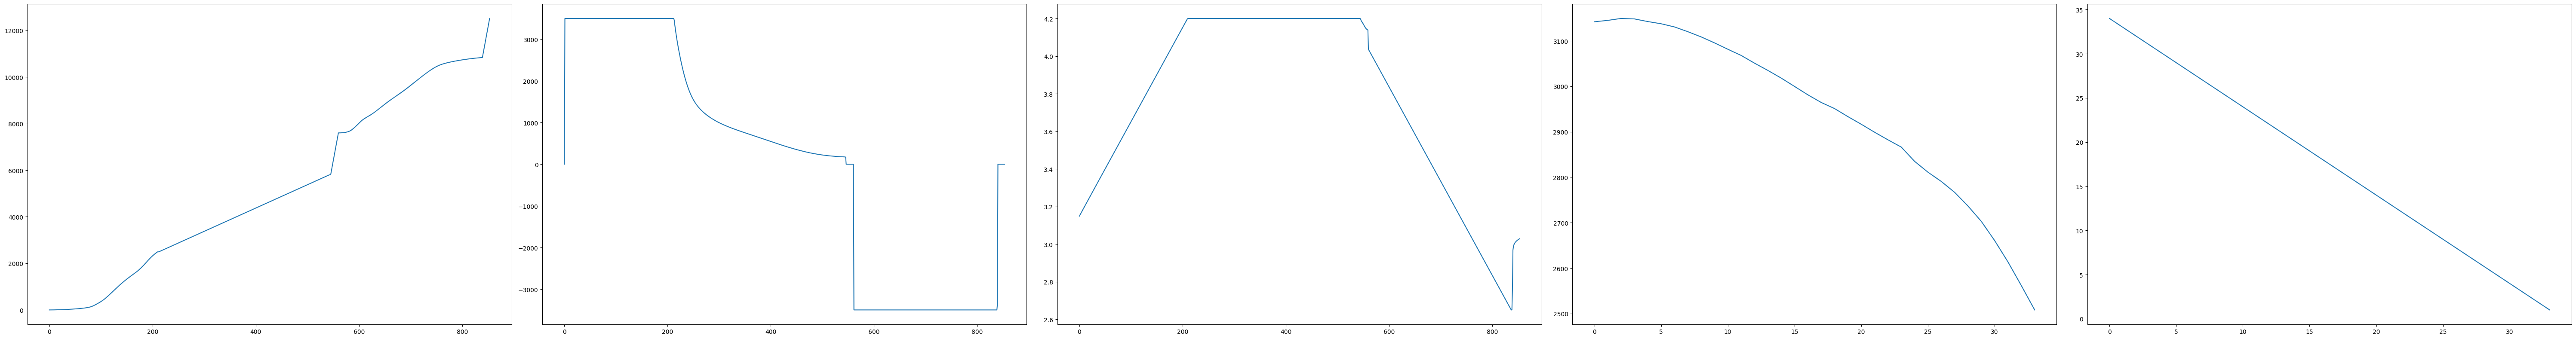

In [41]:

data_path = "./CY25-1_1-#1.pkl"
data = np.load(data_path, allow_pickle=True)

# idx, time, Current, Ecell, Tem, np.max(Q_dis), rul

print(data.shape) # (34, 7),34条样本,每条样本是一个充放电循环,特征如上(4个),最后三个温度,容量,剩余寿命是标签

for i in data:
    # 创建一个包五个子图的图表
    fig, axs = plt.subplots(1, 5, figsize=(60, 8))
    axs[0].plot(i[1])
    axs[1].plot(i[2])
    axs[2].plot(i[3])
    # 采样测试
    # resampled_v_fft = signal.resample(i[3], 128) # 默认为fft采样
    # axs[3].plot(resampled_v_fft)
    axs[3].plot(data[:, -2]) # soh
    axs[4].plot(data[:, -1]) # rul
    plt.tight_layout()
    plt.show()
    break

# 注意这里的数据都没有归一化